# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [8]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [9]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [10]:
NUM_LINES = 3

In [11]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [12]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [13]:
BASELINE_OUTCOME_TO_COLOR = {'lose_trial': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission_trial': "red",
 'omission_baseline': "hotpink",
 'rewarded_trial': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win_trial': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [14]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [15]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [16]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [17]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec']

In [18]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [19]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [20]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [21]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [22]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

### Getting the subject IDs from the file name

In [23]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [24]:
all_trials_df.head()

time  state                                      recording_dir  \
0   6310663.0    1.0  20221202_134600_omission_and_competition_subje...   
1   7910662.0    1.0  20221202_134600_omission_and_competition_subje...   
2   9710660.0    1.0  20221202_134600_omission_and_competition_subje...   
3  11310658.0    1.0  20221202_134600_omission_and_competition_subje...   
4  12810657.0    1.0  20221202_134600_omission_and_competition_subje...   

                                      recording_file           din  \
0  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
1  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
2  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
3  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
4  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1390826.0  20221202_134600_omission_and_competition_subje...   
1         2990825.0  20221202_134600_omission_and_competition_subje...   
2         4790823.0  20221202_134600_omission_and_competition_subje...   
3         6390821.0  20221202_134600_omission_and_competition_subje...   
4         7890820.0  20221202_134600_omission_and_competition_subje...   

   video_frame  video_number      subject_info condition  \
0       1734.0           1.0  6_1_top_2_base_3  rewarded   
1       3728.0           1.0  6_1_top_2_base_3  rewarded   
2       5972.0           1.0  6_1_top_2_base_3  rewarded   
3       7966.0           1.0  6_1_top_2_base_3  omission   
4       9836.0           1.0  6_1_top_2_base_3  rewarded   

  competition_closeness Unnamed: 13  
0                   NaN         NaN  
1                   NaN         NaN  
2                   NaN         NaN  
3                   NaN         NaN  
4                   NaN         NaN

- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [25]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [26]:
all_trials_df["recording_dir"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221214_125409_om_and_comp_6_1_and_6_3',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [27]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [28]:
all_trials_df["all_subjects"].head()

0    [6.1, 6.2]
1    [6.1, 6.2]
2    [6.1, 6.2]
3    [6.1, 6.2]
4    [6.1, 6.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [29]:
all_trials_df["subject_info"].head()

0    6_1_top_2_base_3
1    6_1_top_2_base_3
2    6_1_top_2_base_3
3    6_1_top_2_base_3
4    6_1_top_2_base_3
Name: subject_info, dtype: object

In [30]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [31]:
all_trials_df.head()

time  state                                      recording_dir  \
0   6310663.0    1.0  20221202_134600_omission_and_competition_subje...   
1   7910662.0    1.0  20221202_134600_omission_and_competition_subje...   
2   9710660.0    1.0  20221202_134600_omission_and_competition_subje...   
3  11310658.0    1.0  20221202_134600_omission_and_competition_subje...   
4  12810657.0    1.0  20221202_134600_omission_and_competition_subje...   

                                      recording_file           din  \
0  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
1  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
2  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
3  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
4  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1390826.0  20221202_134600_omission_and_competition_subje...   
1         2990825.0  20221202_134600_omission_and_competition_subje...   
2         4790823.0  20221202_134600_omission_and_competition_subje...   
3         6390821.0  20221202_134600_omission_and_competition_subje...   
4         7890820.0  20221202_134600_omission_and_competition_subje...   

   video_frame  video_number      subject_info condition  \
0       1734.0           1.0  6_1_top_2_base_3  rewarded   
1       3728.0           1.0  6_1_top_2_base_3  rewarded   
2       5972.0           1.0  6_1_top_2_base_3  rewarded   
3       7966.0           1.0  6_1_top_2_base_3  omission   
4       9836.0           1.0  6_1_top_2_base_3  rewarded   

  competition_closeness Unnamed: 13  resampled_index all_subjects  \
0                   NaN         NaN          69541.0   [6.1, 6.2]   
1                   NaN         NaN         149541.0   [6.1, 6.2]   
2                   NaN         NaN         239541.0   [6.1, 6.2]   
3                   NaN         NaN         319541.0   [6.1, 6.2]   
4                   NaN         NaN         394541.0   [6.1, 6.2]   

  current_subject  
0             6.1  
1             6.1  
2             6.1  
3             6.1  
4             6.1

- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [32]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [33]:
all_trials_df.head()

time  state                                      recording_dir  \
0   6310663.0    1.0  20221202_134600_omission_and_competition_subje...   
1   7910662.0    1.0  20221202_134600_omission_and_competition_subje...   
2   9710660.0    1.0  20221202_134600_omission_and_competition_subje...   
3  11310658.0    1.0  20221202_134600_omission_and_competition_subje...   
4  12810657.0    1.0  20221202_134600_omission_and_competition_subje...   

                                      recording_file           din  \
0  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
1  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
2  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
3  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   
4  20221202_134600_omission_and_competition_subje...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1390826.0  20221202_134600_omission_and_competition_subje...   
1         2990825.0  20221202_134600_omission_and_competition_subje...   
2         4790823.0  20221202_134600_omission_and_competition_subje...   
3         6390821.0  20221202_134600_omission_and_competition_subje...   
4         7890820.0  20221202_134600_omission_and_competition_subje...   

   video_frame  video_number      subject_info condition  \
0       1734.0           1.0  6_1_top_2_base_3  rewarded   
1       3728.0           1.0  6_1_top_2_base_3  rewarded   
2       5972.0           1.0  6_1_top_2_base_3  rewarded   
3       7966.0           1.0  6_1_top_2_base_3  omission   
4       9836.0           1.0  6_1_top_2_base_3  rewarded   

  competition_closeness Unnamed: 13  resampled_index all_subjects  \
0                   NaN         NaN          69541.0   [6.1, 6.2]   
1                   NaN         NaN         149541.0   [6.1, 6.2]   
2                   NaN         NaN         239541.0   [6.1, 6.2]   
3                   NaN         NaN         319541.0   [6.1, 6.2]   
4                   NaN         NaN         394541.0   [6.1, 6.2]   

  current_subject trial_outcome  
0             6.1      rewarded  
1             6.1      rewarded  
2             6.1      rewarded  
3             6.1      omission  
4             6.1      rewarded

In [34]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [35]:
competition_closeness_map

{nan: nan,
 'Subj 1 Only': 'non_comp',
 'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 2 Only': 'non_comp',
 'Subj 2 then Subj 1': 'comp',
 'Close Call': 'comp'}

In [36]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [37]:
all_trials_df["competition_closeness"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
698    non_comp
699    non_comp
700        comp
701        comp
702        comp
Name: competition_closeness, Length: 703, dtype: object

In [38]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [39]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged


- Filtering for all trials that have labels

In [40]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [41]:
all_trials_df.head()

time  state                            recording_dir  \
0   4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1   5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2   7759946.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
3   9359945.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
4  10859943.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file           din  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2         4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3         6408042.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4         7908040.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

   video_frame  video_number             subject_info condition  \
0       1405.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
1       3002.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
2       4798.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
3       6395.0           1.0  6_1_top_1_base_2_vs_6_3  omission   
4       7892.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   

  competition_closeness Unnamed: 13  resampled_index all_subjects  \
0              rewarded         NaN          70402.0   [6.1, 6.3]   
1              rewarded         NaN         150402.0   [6.1, 6.3]   
2              rewarded         NaN         240402.0   [6.1, 6.3]   
3              omission         NaN         320402.0   [6.1, 6.3]   
4              rewarded         NaN         395402.0   [6.1, 6.3]   

  current_subject trial_outcome  
0             6.1      rewarded  
1             6.1      rewarded  
2             6.1      rewarded  
3             6.1      omission  
4             6.1      rewarded

In [42]:
all_trials_df["trial_outcome"].unique()

array(['rewarded', 'omission', 'win', 'lose'], dtype=object)

In [43]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'])

In [44]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

## Power Correlation Calculation

In [45]:
all_trials_df.head()

time  state                            recording_dir  \
0   4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1   5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2   7759946.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
3   9359945.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
4  10859943.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file           din  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2         4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3         6408042.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4         7908040.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

   video_frame  video_number             subject_info condition  \
0       1405.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
1       3002.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
2       4798.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
3       6395.0           1.0  6_1_top_1_base_2_vs_6_3  omission   
4       7892.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   

  competition_closeness Unnamed: 13  resampled_index all_subjects  \
0              rewarded         NaN          70402.0   [6.1, 6.3]   
1              rewarded         NaN         150402.0   [6.1, 6.3]   
2              rewarded         NaN         240402.0   [6.1, 6.3]   
3              omission         NaN         320402.0   [6.1, 6.3]   
4              rewarded         NaN         395402.0   [6.1, 6.3]   

  current_subject trial_outcome  
0             6.1      rewarded  
1             6.1      rewarded  
2             6.1      rewarded  
3             6.1      omission  
4             6.1      rewarded

- Adding all the brain region to ch information

In [46]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [47]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

In [48]:
channel_map_and_all_trials_df

time  state                                      recording_dir  \
0     4359951.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
1     5959954.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
2     7759946.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
3     9359945.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
4    10859943.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
..          ...    ...                                                ...   
632  29281401.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
633  30881425.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
634  32281440.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
635  34481464.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
636  35681479.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                        recording_file           din  \
0    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
..                                                 ...           ...   
632  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
633  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
634  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
635  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
636  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

     time_stamp_index                                         video_file  \
0           1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1           3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2           4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3           6408042.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4           7908040.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
..                ...                                                ...   
632        26088357.0  20230621_111240_standard_comp_to_omission_D5_s...   
633        27688381.0  20230621_111240_standard_comp_to_omission_D5_s...   
634        29088396.0  20230621_111240_standard_comp_to_omission_D5_s...   
635        31288420.0  20230621_111240_standard_comp_to_omission_D5_s...   
636        32488435.0  20230621_111240_standard_comp_to_omission_D5_s...   

     video_frame  video_number             subject_info  ... eib_vHPC eib_BLA  \
0         1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...       15      14   
1         3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...       15      14   
2         4798.0           1.0  6_1_top_1_base_2_vs_6_3  ...       15      14   
3         6395.0           1.0  6_1_top_1_base_2_vs_6_3  ...       15      14   
4         7892.0           1.0  6_1_top_1_base_2_vs_6_3  ...       15      14   
..           ...           ...                      ...  ...      ...     ...   
632      26040.0           2.0           1-4_t3b3L_box1  ...       15      14   
633      27636.0           2.0           1-4_t3b3L_box1  ...       15      14   
634      29033.0           2.0           1-4_t3b3L_box1  ...       15      14   
635      31230.0           2.0           1-4_t3b3L_box1  ...       15      14   
636      32427.0           2.0           1-4_t3b3L_box1  ...       15      14   

    eib_LH  eib_MD spike_interface_mPFC spike_interface_vHPC  \
0       13      31                 21.0                 15.0   
1       13      31                 21.0                 15.0   
2       13      31                 21.0                 15.0   
3       13      31                 21.0                 15.0   
4       13     

- Getting the LFP for trial

In [49]:
channel_map_and_all_trials_df["resampled_index"] = channel_map_and_all_trials_df["resampled_index"].astype(int)

In [50]:
trial_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()
trial_channel_map_and_all_trials_df["trial_or_baseline"] = "trial"
trial_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = trial_channel_map_and_all_trials_df["resampled_index"].apply(lambda x: (x, x+RESAMPLE_RATE*TRIAL_DURATION,))


baseline_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()
baseline_channel_map_and_all_trials_df["trial_or_baseline"] = "baseline"
baseline_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = baseline_channel_map_and_all_trials_df["resampled_index"].apply(lambda x: (x-RESAMPLE_RATE*TRIAL_DURATION, x))

In [51]:
channel_map_and_all_trials_df = pd.concat([trial_channel_map_and_all_trials_df, baseline_channel_map_and_all_trials_df])

In [52]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"].head()

0      (70402, 80402)
1    (150402, 160402)
2    (240402, 250402)
3    (320402, 330402)
4    (395402, 405402)
Name: trial_or_baseline_entire_lfp_index, dtype: object

In [53]:
channel_columns = sorted([col for col in channel_map_and_all_trials_df.columns if "spike" in col])

In [54]:
channel_columns

['spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD',
 'spike_interface_mPFC',
 'spike_interface_vHPC']

In [55]:
for col in channel_columns:
    print(col)
    channel_map_and_all_trials_df["{}_trace".format(col.strip("spike_interface").strip("_"))] = channel_map_and_all_trials_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[str(int(x[col]))], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ).T[0][:RESAMPLE_RATE*TRIAL_DURATION], axis=1)

spike_interface_BLA
spike_interface_LH
spike_interface_MD
spike_interface_mPFC
spike_interface_vHPC


In [56]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [57]:
trace_columns

['BLA_trace', 'LH_trace', 'MD_trace', 'mPFC_trace', 'vHPC_trace']

In [58]:
channel_map_and_all_trials_df["BLA_trace"].iloc[0].shape

(10000,)

In [59]:
low_freq = 4
high_freq = 12

In [60]:
for region in trace_columns:
    
    region_base_name = "{}".format(region.strip("trace").strip("_"))
    print(region_base_name)
    try:
        multitaper_col = "{}_multitaper".format(region_base_name)
        channel_map_and_all_trials_df[multitaper_col] = channel_map_and_all_trials_df[region].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE))
    
        connectivity_col = "{}_connectivity".format(region_base_name)
        channel_map_and_all_trials_df[connectivity_col] = channel_map_and_all_trials_df[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        channel_map_and_all_trials_df["{}_frequencies".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.frequencies)

        channel_map_and_all_trials_df["{}_power".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.power().squeeze())

        channel_map_and_all_trials_df["{}_averaged_theta_power".format(region_base_name)] = channel_map_and_all_trials_df["{}_power".format(region_base_name)].apply(lambda x: np.mean(x[low_freq*10:high_freq*10+1]))

    except Exception as e: 
        print(e)

BLA
LH
MD
mPFC
vHPC


In [61]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_theta" in col]

In [62]:
brain_region_pairs = generate_pairs(trace_columns)

In [63]:
brain_region_pairs

[('BLA_averaged_theta_power', 'LH_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'MD_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('BLA_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('LH_averaged_theta_power', 'MD_averaged_theta_power'),
 ('LH_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('LH_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('MD_averaged_theta_power', 'mPFC_averaged_theta_power'),
 ('MD_averaged_theta_power', 'vHPC_averaged_theta_power'),
 ('mPFC_averaged_theta_power', 'vHPC_averaged_theta_power')]

In [64]:
averaged_col = [col for col in channel_map_and_all_trials_df.columns if "averaged" in col]

In [85]:
# Calculate the mean and standard deviation for each column
mean = channel_map_and_all_trials_df[averaged_col].median()
std_dev = channel_map_and_all_trials_df[averaged_col].std()



In [95]:
channel_map_and_all_trials_df["BLA_averaged_theta_power"].min()

0.0

In [86]:
mean

BLA_averaged_theta_power     0.020169
LH_averaged_theta_power      0.027256
MD_averaged_theta_power      0.029183
mPFC_averaged_theta_power    0.024283
vHPC_averaged_theta_power    0.026316
dtype: float64

In [92]:
std_dev

BLA_averaged_theta_power     1.272491
LH_averaged_theta_power      0.464413
MD_averaged_theta_power      0.550395
mPFC_averaged_theta_power    0.423190
vHPC_averaged_theta_power    0.211516
dtype: float64

In [91]:
(channel_map_and_all_trials_df[averaged_col] - mean).abs() 

BLA_averaged_theta_power  LH_averaged_theta_power  \
0                    0.001483                 0.000205   
1                    0.007425                 0.000576   
2                    0.001790                 0.000134   
3                    0.001176                 0.003445   
4                    0.001361                 0.004691   
..                        ...                      ...   
632                  0.001509                 0.007645   
633                  0.000449                 0.008031   
634                  0.000734                 0.002859   
635                  0.003512                 0.000866   
636                  0.003925                 0.001199   

     MD_averaged_theta_power  mPFC_averaged_theta_power  \
0                   0.004951                   0.000380   
1                   0.004416                   0.009549   
2                   0.004153                   0.009944   
3                   0.002065                   0.002228   
4                   0.002047                   0.003876   
..                       ...                        ...   
632                 0.005424                   0.001972   
633                 0.006722                   0.000595   
634                 0.000612                   0.001114   
635                 0.003334                   0.006218   
636                 0.003964                   0.001433   

     vHPC_averaged_theta_power  
0                     0.015987  
1                     0.004624  
2                     0.000968  
3                     0.003774  
4                     0.003537  
..                         ...  
632                   0.004907  
633                   0.004684  
634                   0.000153  
635                   0.000271  
636                   0.003035  

[1274 rows x 5 columns]

In [125]:
back_up_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()

In [151]:
filtered_df = back_up_channel_map_and_all_trials_df.copy()
for col in averaged_col:
    # filtered_df = filtered_df[filtered_df[col] <= 3]
    # Assuming data is a 1D numpy array
    Q1 = np.percentile(filtered_df[col], 25)
    Q3 = np.percentile(filtered_df[col], 75)
    IQR = Q3 - Q1
    filtered_df = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]

In [149]:
filtered_df = back_up_channel_map_and_all_trials_df.copy()
for col in averaged_col:
    # Assuming data is a 1D numpy array
    threshold = 3.5
    mean = np.mean(filtered_df[col])
    std = np.std(filtered_df[col])
    filtered_df = filtered_df[np.abs(filtered_df[col] - mean) < threshold * std]

In [152]:
filtered_df

time  state                                      recording_dir  \
0     4359951.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
1     5959954.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
2     7759946.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
3     9359945.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
4    10859943.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
..          ...    ...                                                ...   
632  29281401.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
633  30881425.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
634  32281440.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
635  34481464.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
636  35681479.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                        recording_file           din  \
0    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4    20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
..                                                 ...           ...   
632  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
633  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
634  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
635  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
636  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

     time_stamp_index                                         video_file  \
0           1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1           3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2           4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3           6408042.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4           7908040.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
..                ...                                                ...   
632        26088357.0  20230621_111240_standard_comp_to_omission_D5_s...   
633        27688381.0  20230621_111240_standard_comp_to_omission_D5_s...   
634        29088396.0  20230621_111240_standard_comp_to_omission_D5_s...   
635        31288420.0  20230621_111240_standard_comp_to_omission_D5_s...   
636        32488435.0  20230621_111240_standard_comp_to_omission_D5_s...   

     video_frame  video_number             subject_info  ...  \
0         1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...   
1         3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...   
2         4798.0           1.0  6_1_top_1_base_2_vs_6_3  ...   
3         6395.0           1.0  6_1_top_1_base_2_vs_6_3  ...   
4         7892.0           1.0  6_1_top_1_base_2_vs_6_3  ...   
..           ...           ...                      ...  ...   
632      26040.0           2.0           1-4_t3b3L_box1  ...   
633      27636.0           2.0           1-4_t3b3L_box1  ...   
634      29033.0           2.0           1-4_t3b3L_box1  ...   
635      31230.0           2.0           1-4_t3b3L_box1  ...   
636      32427.0           2.0           1-4_t3b3L_box1  ...   

                                     mPFC_connectivity  \
0    <spectral_connectivity.connectivity.Connectivi...   
1    <spectral_connectivity.connectivity.Connectivi...   
2    <spectral_connectivity.connectivity.Connectivi...   
3    <spectral_connectivity.connectivity.Connectivi...   
4    <spectral_connectivity.connectivity.Connectivi...   
..                                                 ...   
632  <spectral_connectivity.connectivity.Connectivi...   
633  <spectral_connectivity.connectivity.Connectivi...   
634  <spectral_co

In [153]:
channel_map_and_all_trials_df = filtered_df

In [154]:
channel_map_and_all_trials_df["outcome_and_trial_or_baseline"] = channel_map_and_all_trials_df.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

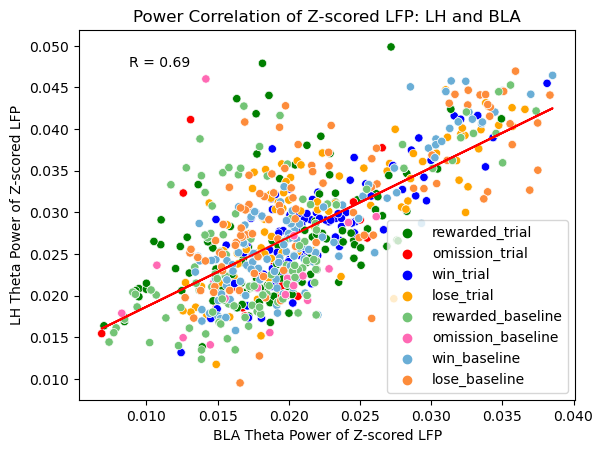

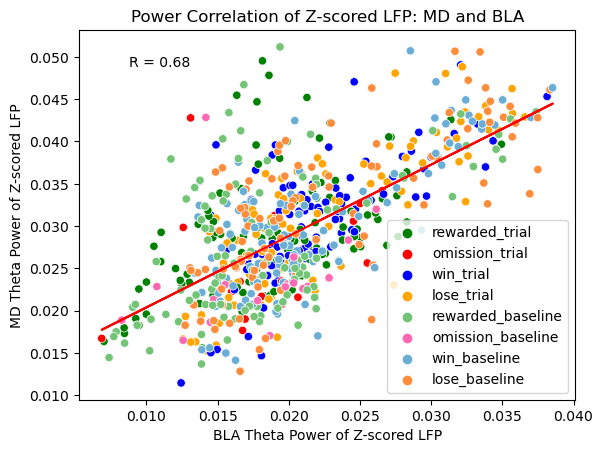

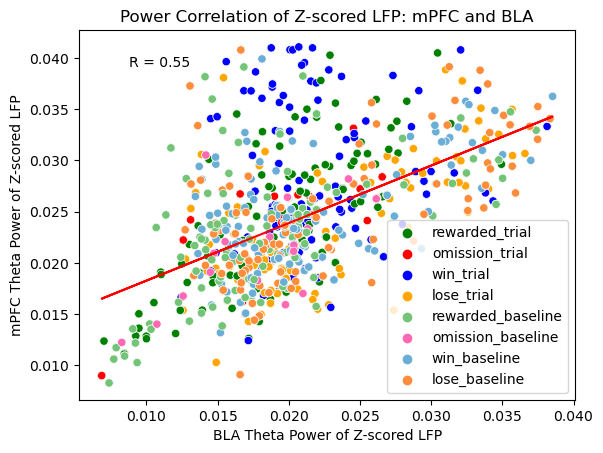

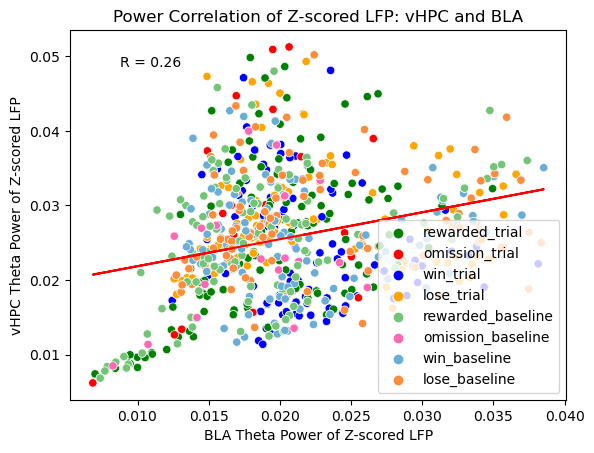

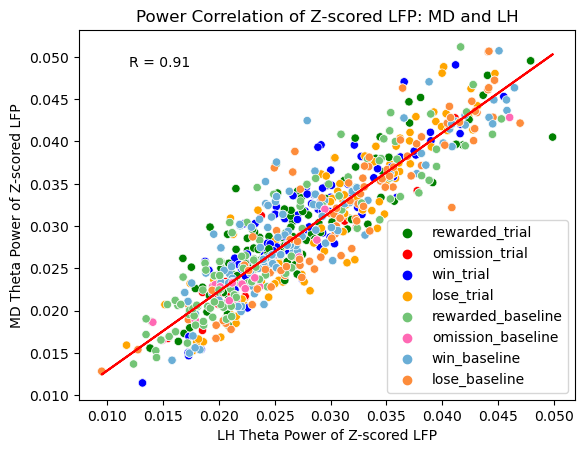

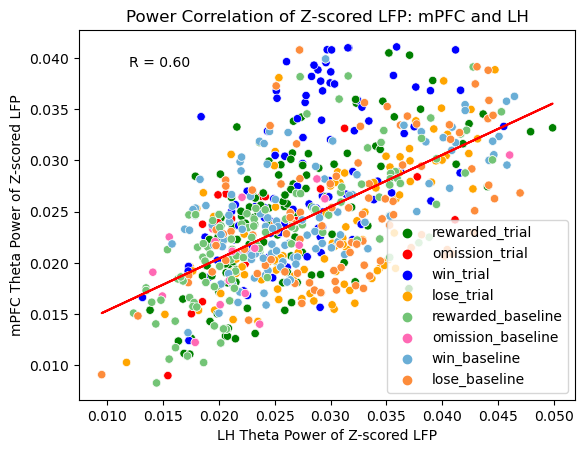

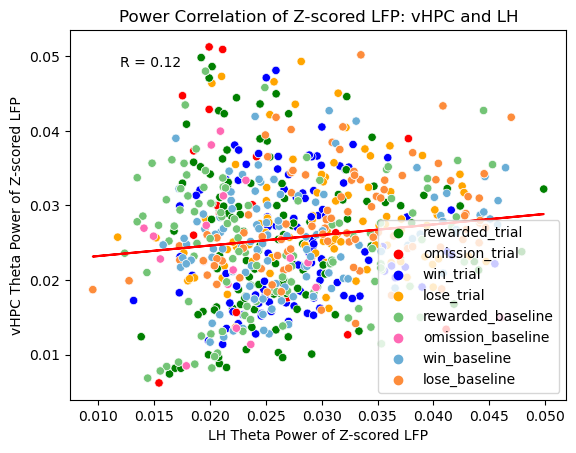

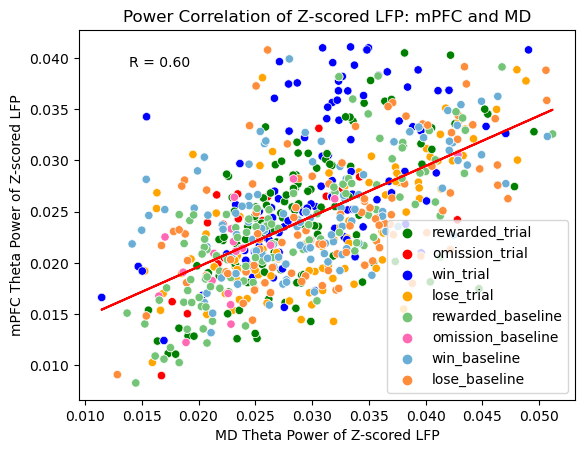

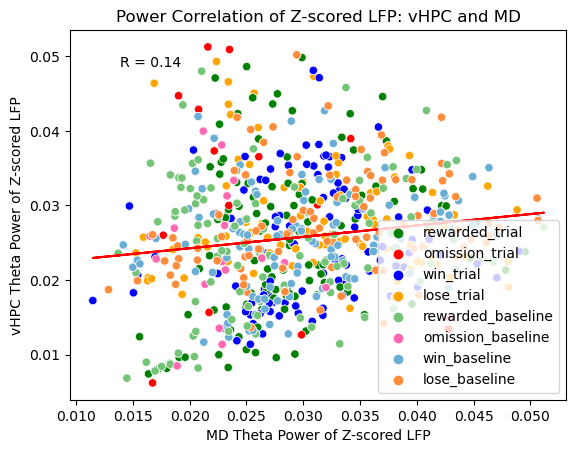

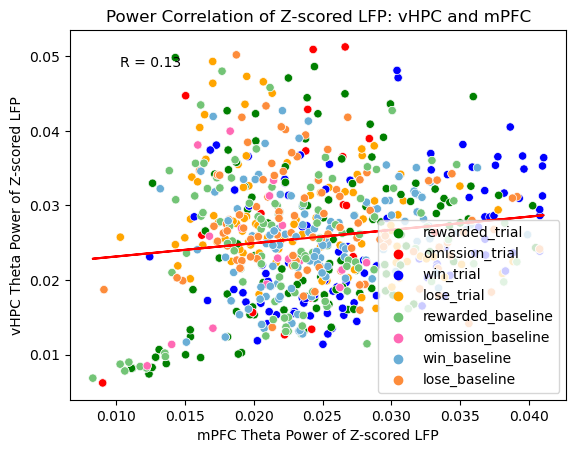

In [161]:
for region_1, region_2 in brain_region_pairs:
    region_1_basename = region_1.split("_")[0]
    region_2_basename = region_2.split("_")[0]
    
    x = channel_map_and_all_trials_df[region_1]
    y = channel_map_and_all_trials_df[region_2]
    
    # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Create a line of best fit using the slope and intercept
    line = slope * x + intercept
    
    # Create scatter plot
    sns.scatterplot(x=x, y=y, data=channel_map_and_all_trials_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
    
    # Plot line of best fit
    plt.plot(x, line, color='red')
    
    # Add R² value to the plot
    plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
    
    # Add labels and legend
    plt.title("Power Correlation of Z-scored LFP: {} and {}".format(region_2_basename, region_1_basename))
    plt.xlabel('{} Theta Power of Z-scored LFP'.format(region_1_basename))
    plt.ylabel('{} Theta Power of Z-scored LFP'.format(region_2_basename))
    plt.legend(loc="lower right")
    plt.savefig("./proc/power_correlation/zscored/all_condition_{}_{}_power_correlation_of_zscored_theta_lfp.png".format(region_1_basename, region_2_basename))
    # Display the plot
    plt.show()
    

In [136]:
channel_map_and_all_trials_df["trial_outcome"].unique()

array(['rewarded', 'omission', 'win', 'lose'], dtype=object)

In [137]:
channel_map_and_all_trials_df["trial_or_baseline"]

0         trial
1         trial
2         trial
3         trial
4         trial
         ...   
632    baseline
633    baseline
634    baseline
635    baseline
636    baseline
Name: trial_or_baseline, Length: 1075, dtype: object

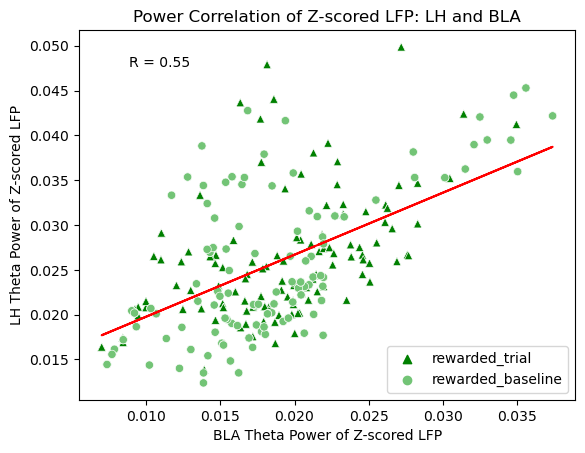

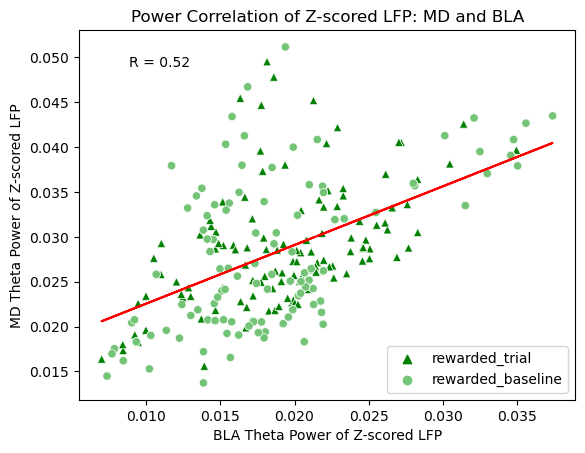

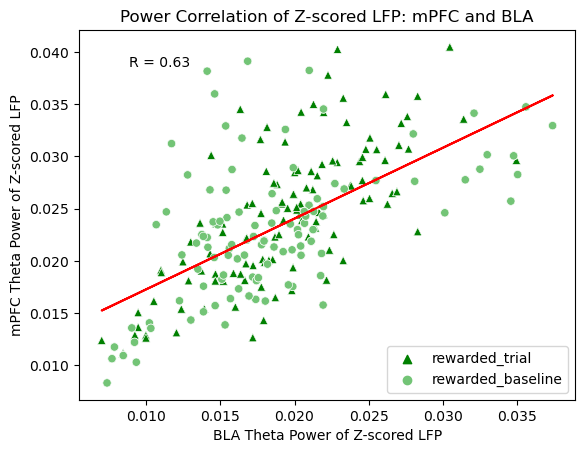

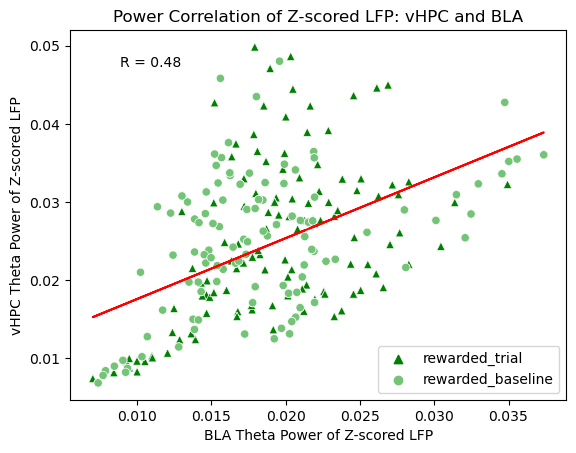

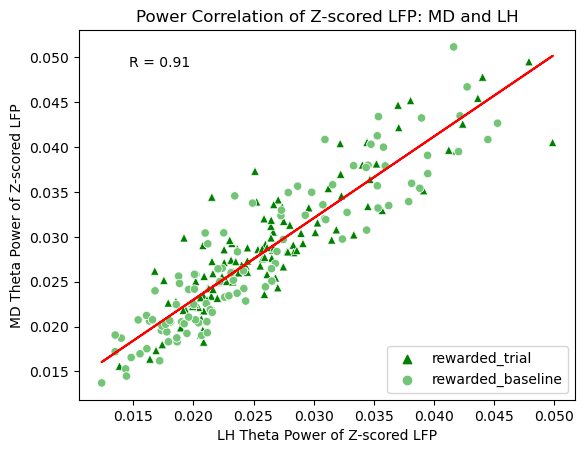

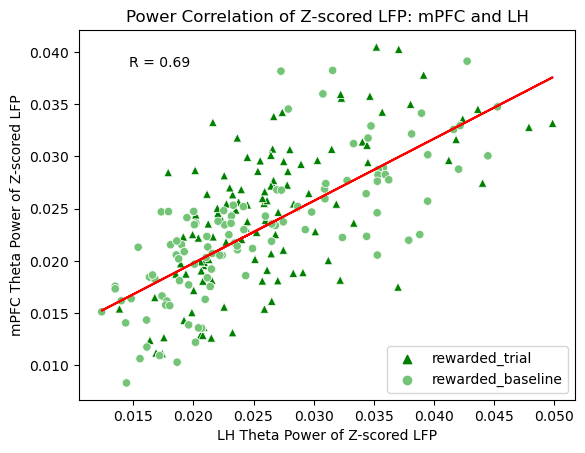

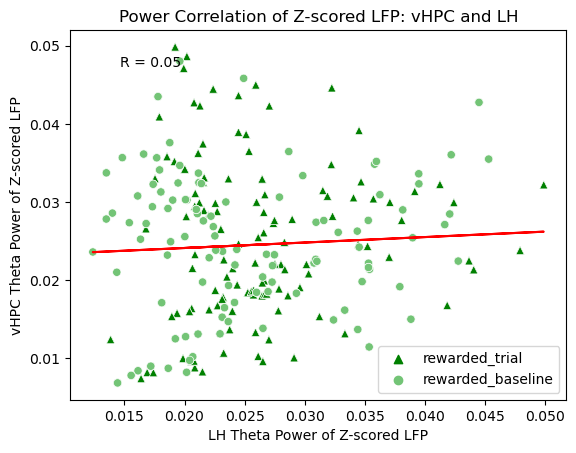

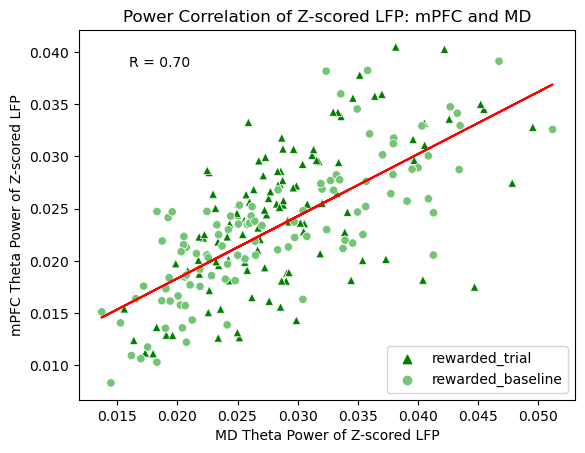

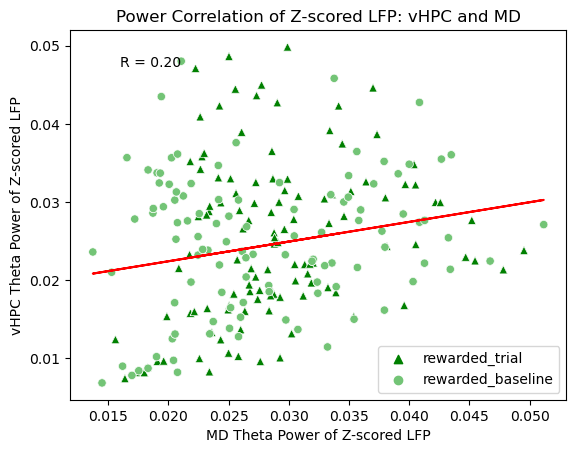

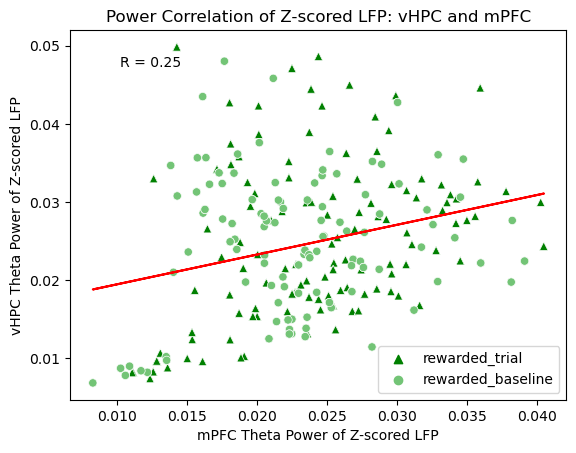

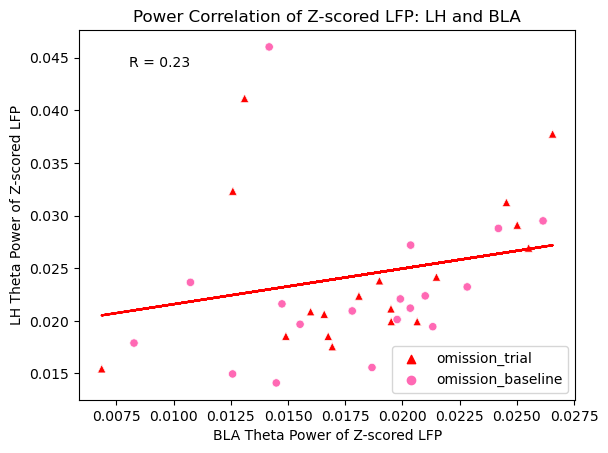

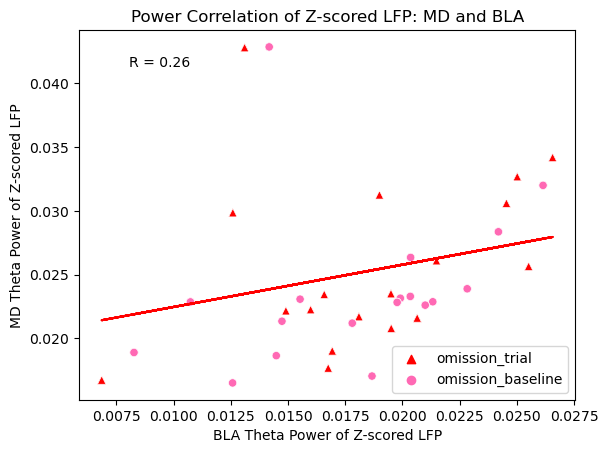

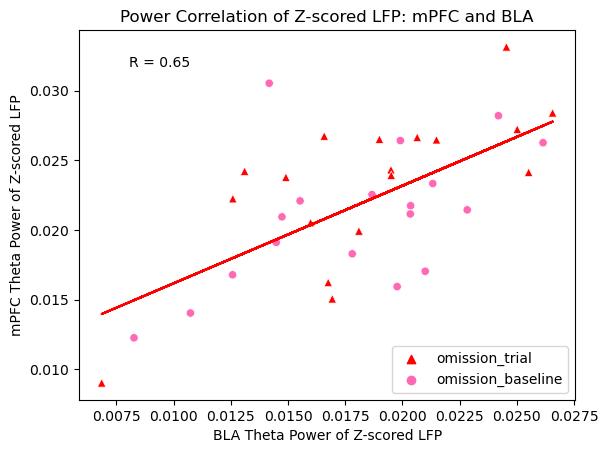

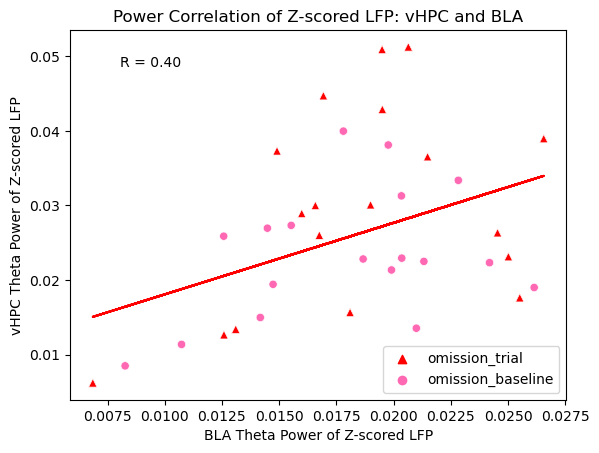

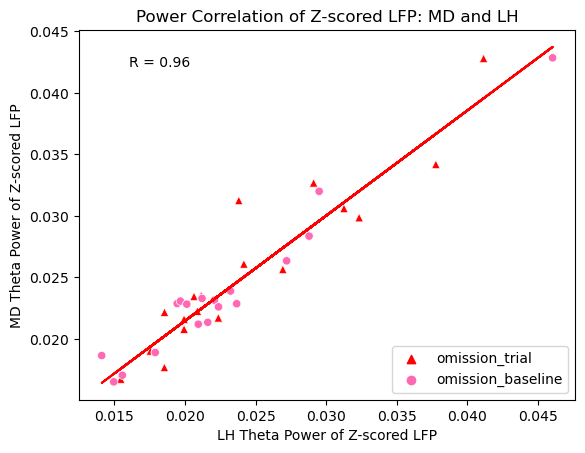

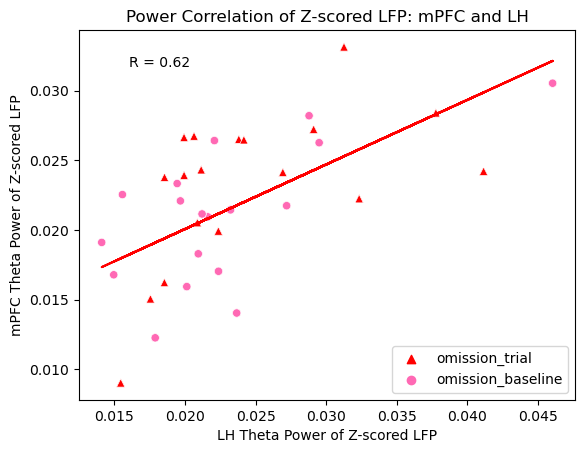

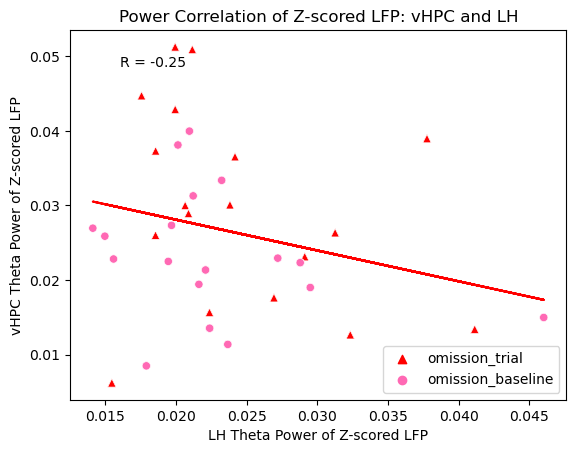

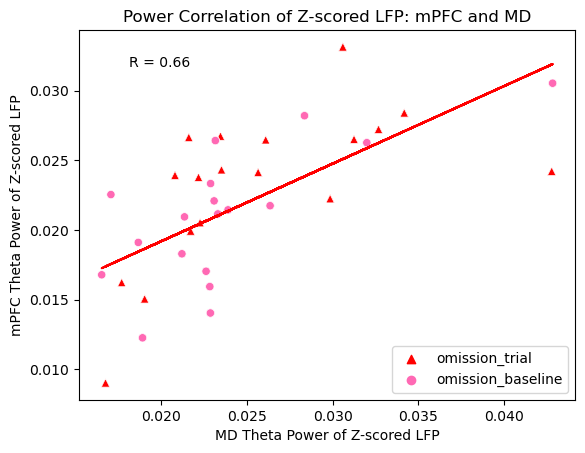

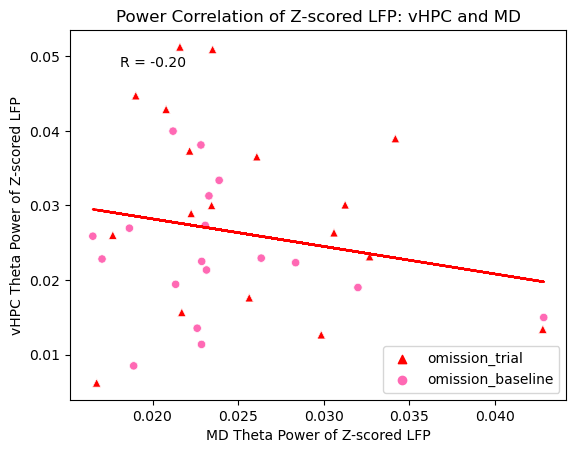

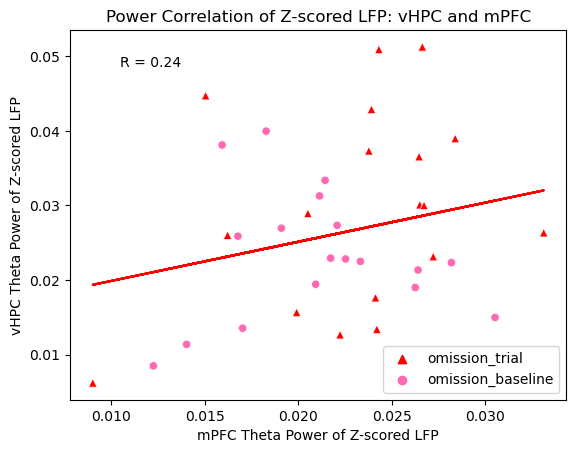

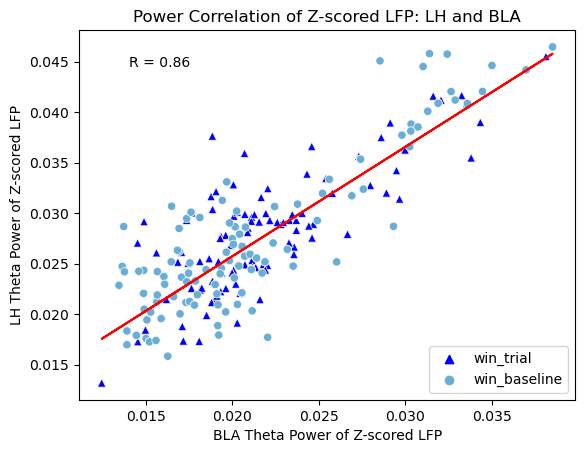

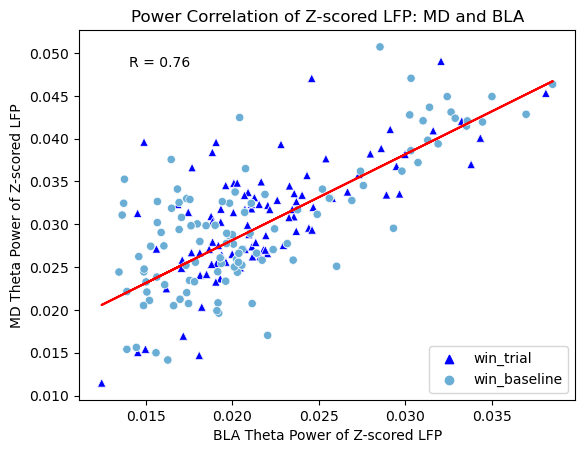

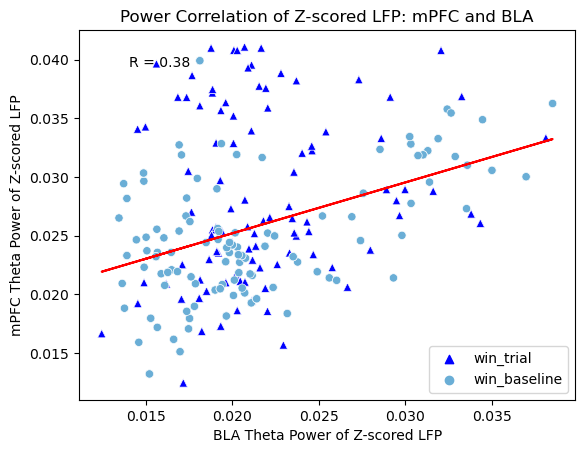

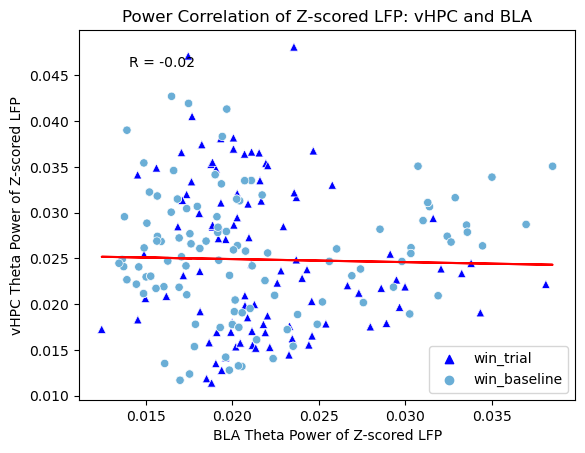

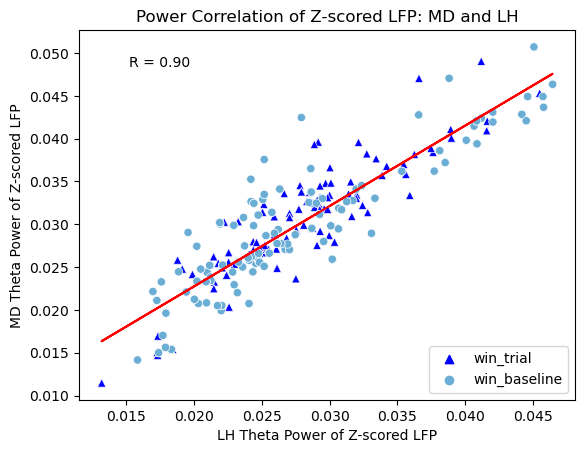

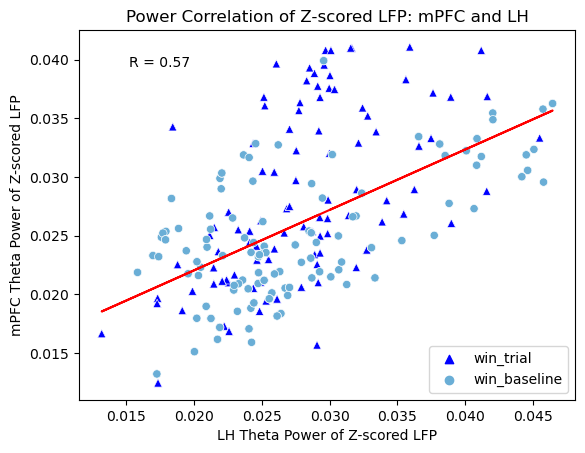

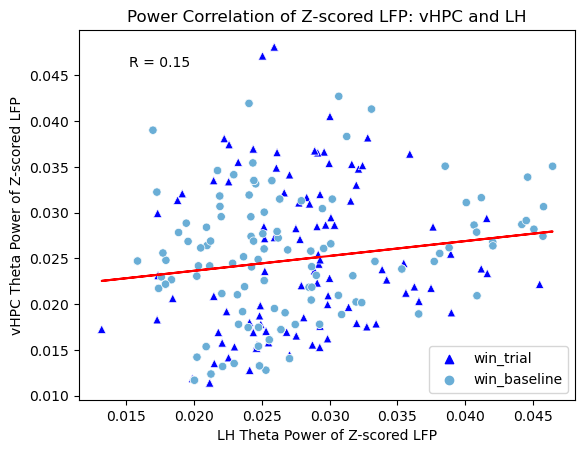

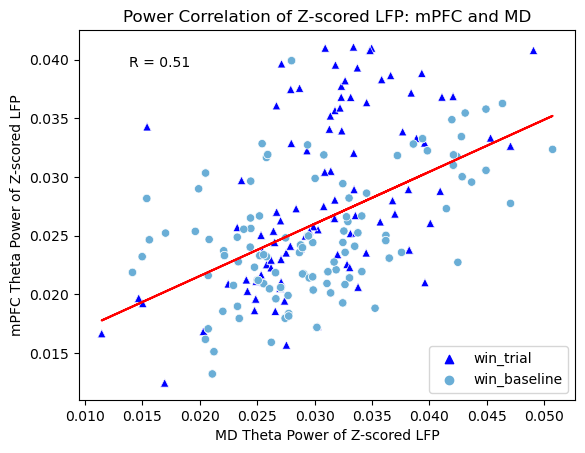

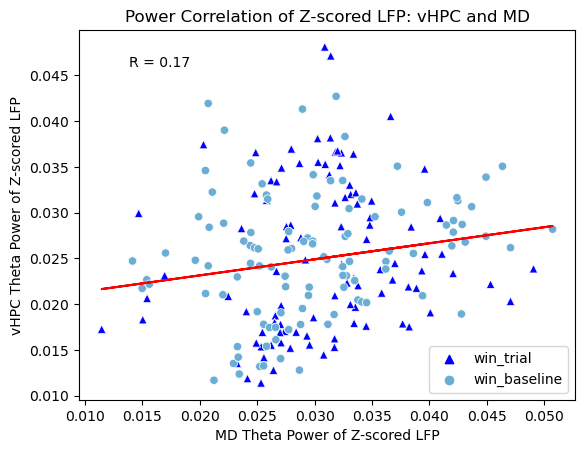

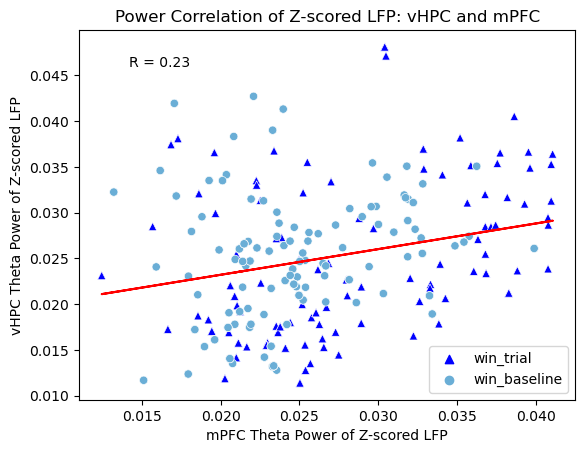

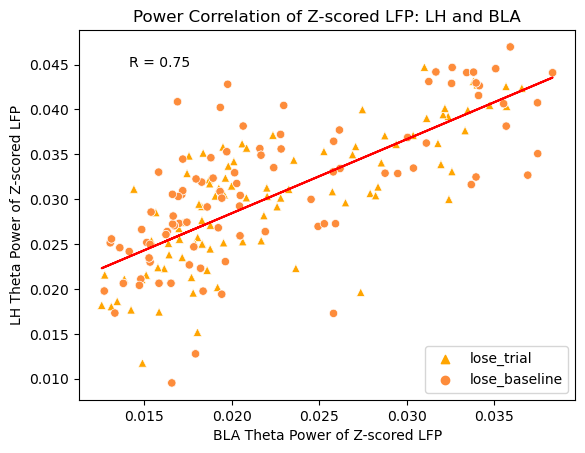

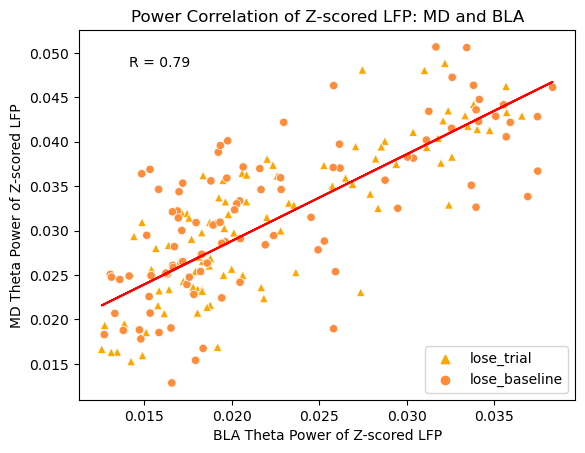

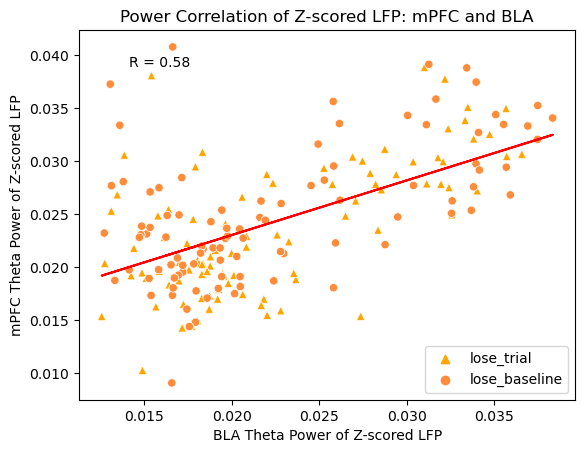

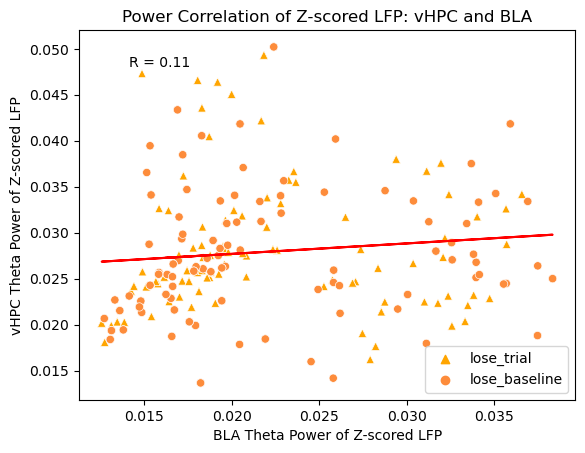

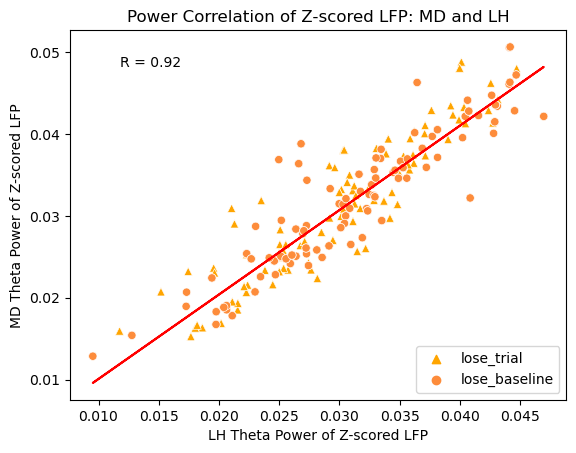

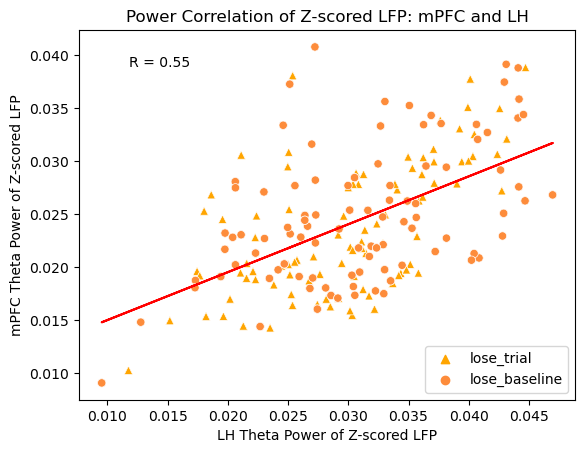

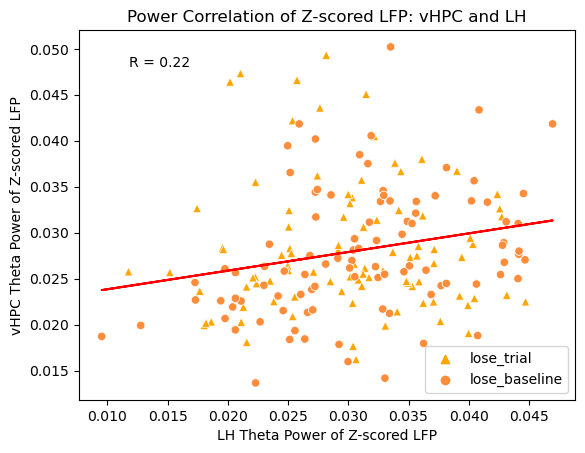

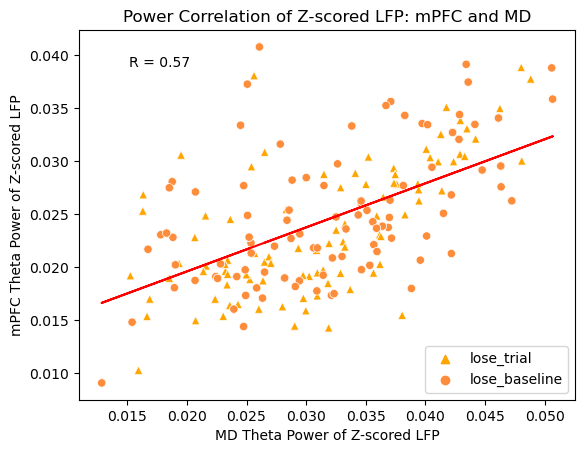

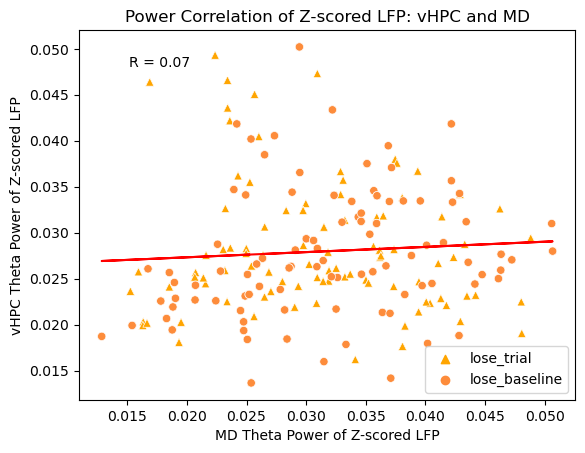

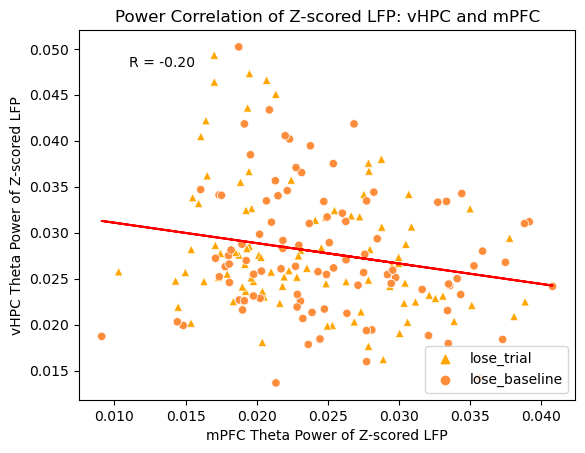

In [162]:
region_pair_to_outcome_to_r2 = defaultdict(nested_dict)
for outcome in channel_map_and_all_trials_df["trial_outcome"].unique():
    outcome_df = channel_map_and_all_trials_df[channel_map_and_all_trials_df["trial_outcome"] == outcome]
    for region_1, region_2 in brain_region_pairs:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        
        x = outcome_df[region_1]
        y = outcome_df[region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        # Square the r value to get the r squared value
        r2_value = r_value**2
        region_pair_to_outcome_to_r2["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
        region_pair_to_outcome_to_r2["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power Correlation of Z-scored LFP: {} and {}".format(region_2_basename, region_1_basename))
        plt.xlabel('{} Theta Power of Z-scored LFP'.format(region_1_basename))
        plt.ylabel('{} Theta Power of Z-scored LFP'.format(region_2_basename))
        plt.legend(loc="lower right")
        plt.savefig("./proc/power_correlation/zscored/{}_{}_{}_power_correlation_of_zscored_theta_lfp.png".format(outcome, region_1_basename, region_2_basename))
        # Display the plot
        plt.show()

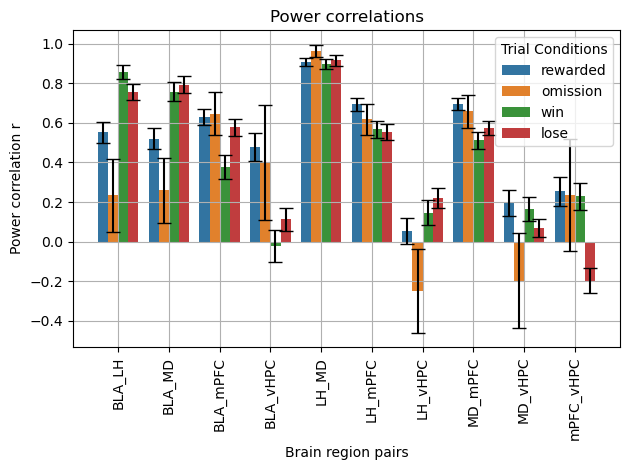

In [159]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()